**TOP 5 CELL LINES WITH LARGEST DIFFERENCE**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

def clean_numeric_columns(df):
    """Convert numeric columns that were read as strings"""
    numeric_cols = ['GR', 'DT', 'Max (L)', 'Midpoint (x0)']
    for col in numeric_cols:
        if col in df.columns:
            # First convert to string in case there are mixed types
            df[col] = df[col].astype(str)
            # Then convert to numeric, coercing errors to NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def compare_outliers(file_path):
    # Load data
    no_outlier_df = pd.read_excel(file_path, sheet_name="NO_OUTLIER")
    outlier_df = pd.read_excel(file_path, sheet_name="OUTLIER_24")

    # Clean data
    no_outlier_df = clean_numeric_columns(no_outlier_df.dropna(subset=['Cell lines']))
    outlier_df = clean_numeric_columns(outlier_df.dropna(subset=['Cell lines']))

    # Verify numeric conversion
    print("NO_OUTLIER numeric columns:")
    display(no_outlier_df[['GR', 'DT', 'Max (L)', 'Midpoint (x0)']].info())

    print("\nOUTLIER_24 numeric columns:")
    display(outlier_df[['GR', 'DT', 'Max (L)', 'Midpoint (x0)']].info())

    # 1. Calculate mean values per cell line
    no_outlier_means = no_outlier_df.groupby('Cell lines')[['GR', 'DT', 'Max (L)', 'Midpoint (x0)']].mean()
    outlier_means = outlier_df.groupby('Cell lines')[['GR', 'DT', 'Max (L)', 'Midpoint (x0)']].mean()

    # 2. Calculate absolute differences
    differences = (no_outlier_means - outlier_means).abs()
    differences['Overall_Difference'] = differences.mean(axis=1)

    # 3. Sort by largest differences
    differences_sorted = differences.sort_values('Overall_Difference', ascending=False)

    # 4. Plot top 5 different cell lines
    top_cell_lines = differences_sorted.head(5).index

    plt.figure(figsize=(15, 8))
    for i, cell_line in enumerate(top_cell_lines, 1):
        plt.subplot(2, 3, i)

        no_vals = no_outlier_means.loc[cell_line]
        out_vals = outlier_means.loc[cell_line]

        metrics = ['GR', 'DT', 'Max (L)', 'Midpoint (x0)']
        x = range(len(metrics))
        width = 0.35

        plt.bar(x, no_vals, width, label='NO_OUTLIER', color='skyblue')
        plt.bar([p + width for p in x], out_vals, width, label='OUTLIER_24', color='salmon')

        plt.title(cell_line)
        plt.xticks([p + width/2 for p in x], metrics, rotation=45)
        plt.ylabel('Value')

        if i == 1:
            plt.legend()

    plt.suptitle('Top 5 Cell Lines with Largest Differences', y=1.02)
    plt.tight_layout()
    plt.show()

    # 5. Display difference table
    print("\nCell Lines Ranked by Differences:")
    display(differences_sorted.head(5))

    # 6. Statistical significance
    print("\nPaired t-test results:")
    common_cell_lines = list(set(no_outlier_means.index) & set(outlier_means.index))
    for metric in ['GR', 'DT', 'Max (L)', 'Midpoint (x0)']:
        _, pval = ttest_rel(
            no_outlier_means.loc[common_cell_lines][metric],
            outlier_means.loc[common_cell_lines][metric]
        )
        print(f"{metric}: p-value = {pval:.4f}")

    return differences_sorted

# Run the analysis
try:
    result = compare_outliers("Outlier_Comparison.xlsx")
except Exception as e:
    print(f"Error encountered: {str(e)}")
    print("\nTry these troubleshooting steps:")
    print("1. Verify your Excel file has no merged cells in data areas")
    print("2. Check for text values in numeric columns (like 'GRGR...' strings)")
    print("3. Manually inspect the first few rows:")
    test_df = pd.read_excel("Outlier_Comparison.xlsx", sheet_name="NO_OUTLIER")
    display(test_df.head(3))

**ENHANCED STATISTICAL COMPARISON**

In [ ]:
# 4. Enhanced Statistical Comparison with Data Alignment Check
print("\nENHANCED STATISTICAL COMPARISON")

# Get common cell lines with complete data
common_cell_lines = list(
    set(no_outlier_df['Cell lines'].dropna()) &
    set(outlier_df['Cell lines'].dropna())
)

# Create aligned DataFrames
no_mean = no_outlier_df[no_outlier_df['Cell lines'].isin(common_cell_lines)] \
    .groupby('Cell lines')[['GR', 'DT', 'Midpoint (x0)']].mean()
out_mean = outlier_df[outlier_df['Cell lines'].isin(common_cell_lines)] \
    .groupby('Cell lines')[['GR', 'DT', 'Midpoint (x0)']].mean()

# Verify alignment
print(f"\nNumber of common cell lines: {len(common_cell_lines)}")
print("Sample cell lines:", list(common_cell_lines)[:5])

# Paired t-test with data validation
results = []
for metric, name in zip(['GR', 'DT', 'Midpoint (x0)'],
                       ['Growth Rate', 'Doubling Time', '50% Confluence']):

    # Check for missing values
    no_vals = no_mean[metric].dropna()
    out_vals = out_mean[metric].reindex(no_vals.index).dropna()

    if len(no_vals) < 3:  # Minimum sample size for t-test
        print(f"\nWarning: Insufficient data ({len(no_vals)} pairs) for {name}")
        continue

    t_stat, p_val = ttest_rel(no_vals, out_vals)
    mean_diff = (out_vals - no_vals).mean()
    pct_diff = (mean_diff/no_vals.mean())*100

    results.append({
        'Metric': name,
        'Cell Lines (n)': len(no_vals),
        'Mean Difference': mean_diff,
        '% Change': pct_diff,
        't-statistic': t_stat,
        'p-value': p_val
    })

# Display formatted results
stats_df = pd.DataFrame(results)
if not stats_df.empty:
    display(stats_df.style
           .format({
               'Mean Difference': '{:.3f}',
               '% Change': '{:.1f}%',
               't-statistic': '{:.3f}',
               'p-value': '{:.4f}'
           })
           .background_gradient(subset=['p-value'], cmap='YlOrRd')
           .bar(subset=['% Change'], align='zero', color=['#d65f5f', '#5fba7d']))
else:
    print("No valid statistical comparisons could be performed.")


ENHANCED STATISTICAL COMPARISON

Number of common cell lines: 159
Sample cell lines: ['mT-TSSK6', 'SBK2-mT', 'SRPK3-mT', 'mT-NEK4', 'mT-CSNK2A2']


,Metric,Cell Lines (n),Mean Difference,% Change,t-statistic,p-value
0,Growth Rate,158,0.001,1.4%,-9.699,0.0000
1,Doubling Time,158,-0.168,-1.3%,8.899,0.0000
2,50% Confluence,158,-0.054,-0.1%,0.910,0.3642


**FIGURE OF ENHANCED STAT DIFF**

<ipython-input-62-e13365ccf2d2>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pos = changes[i] + 0.5 if changes[i] >=0 else changes[i] - 0.5


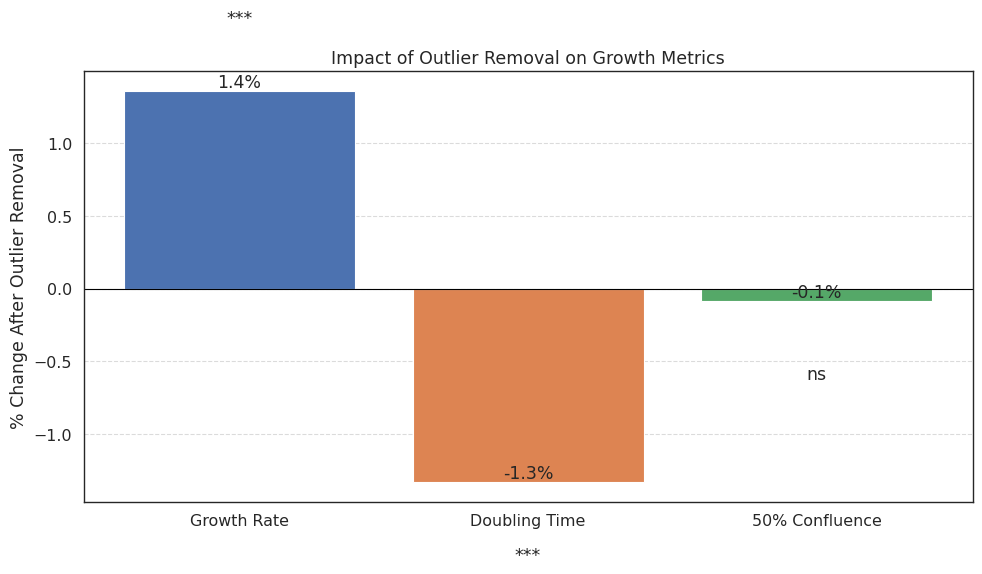

In [ ]:
# Create a summary plot of the statistical results
plt.figure(figsize=(10, 6))

# Prepare data
metrics = ['Growth Rate', 'Doubling Time', '50% Confluence']
changes = stats_df.set_index('Metric')['% Change']

# Bar plot with significance markers
bars = plt.bar(metrics, changes, color=['#4c72b0', '#dd8452', '#55a868'])

# Add significance markers
for i, pval in enumerate(stats_df['p-value']):
    if pval < 0.001:
        marker = '***'
    elif pval < 0.01:
        marker = '**'
    elif pval < 0.05:
        marker = '*'
    else:
        marker = 'ns'

    y_pos = changes[i] + 0.5 if changes[i] >=0 else changes[i] - 0.5
    plt.text(i, y_pos, marker, ha='center', va='center')

# Formatting
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('% Change After Outlier Removal')
plt.title('Impact of Outlier Removal on Growth Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact percentages as labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

**HEATMAP**

<ipython-input-60-8ee2292173a7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col].astype(str), errors='coerce')
<ipython-input-60-8ee2292173a7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col].astype(str), errors='coerce')
<ipython-input-60-8ee2292173a7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Error: The number of FixedLocator locations (40), usually from a call to set_ticks, does not match the number of labels (160).


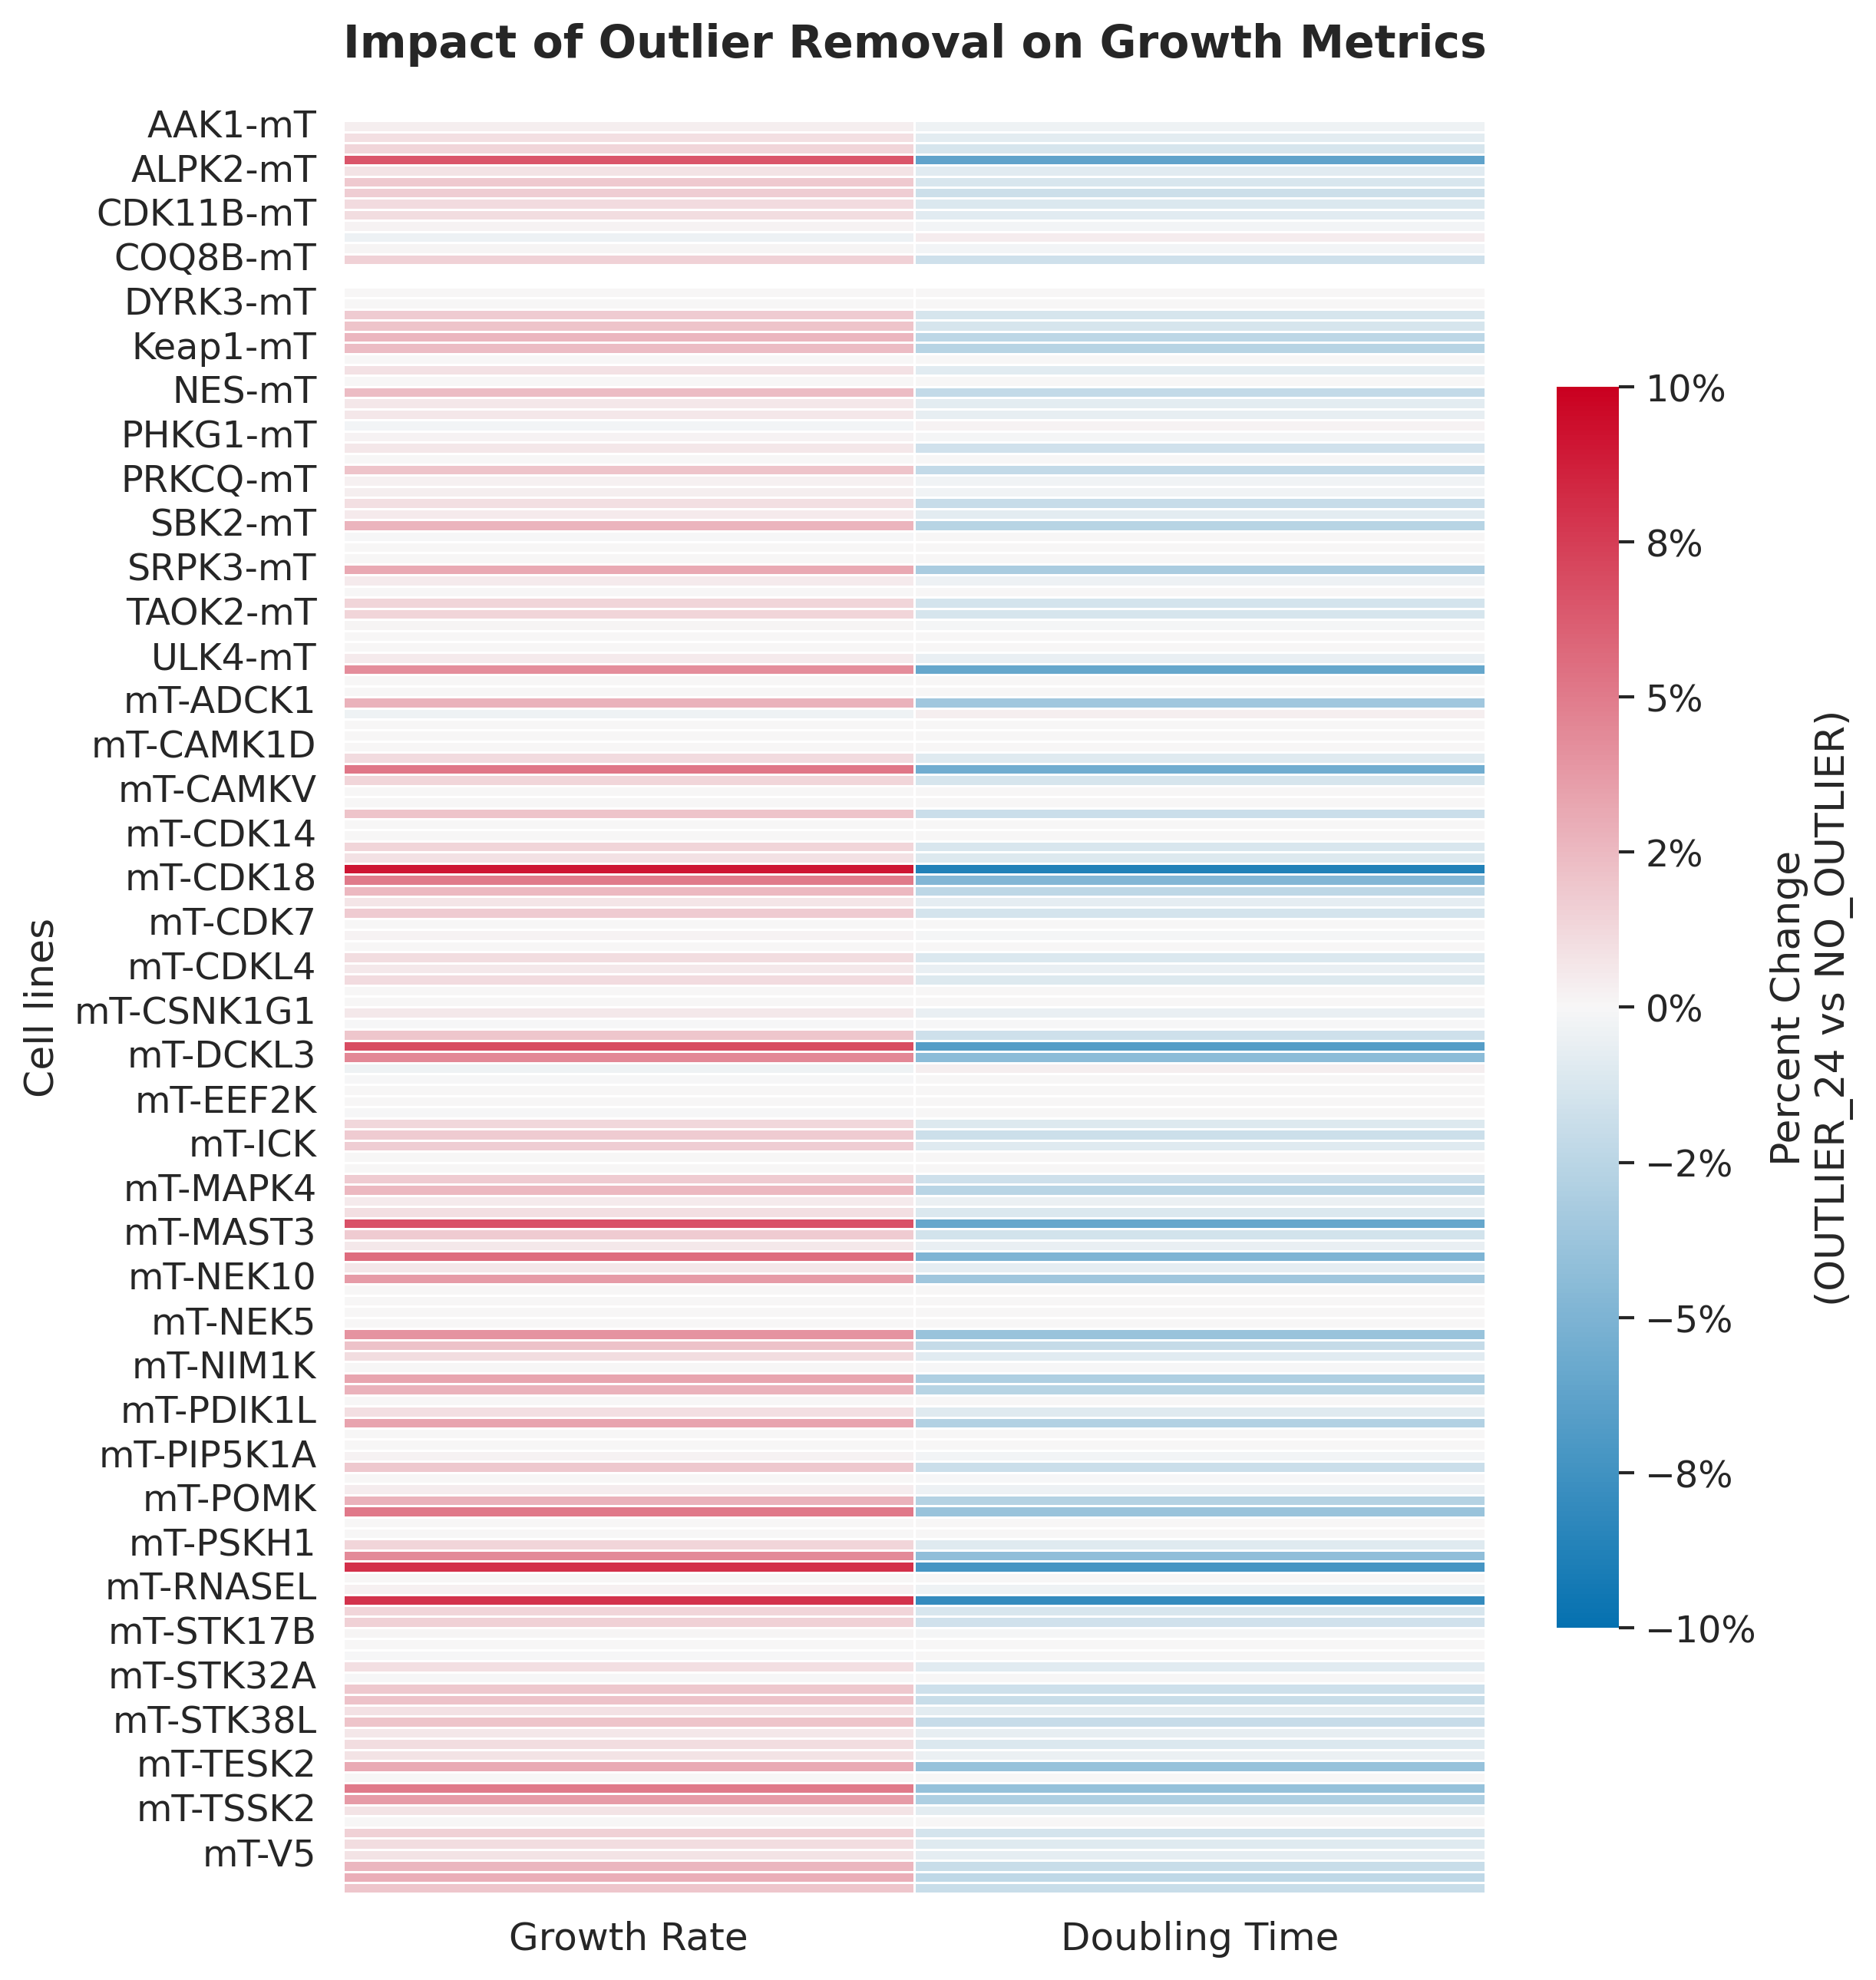

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker


#1.SETUP & CONFIGURATION

sns.set_style("white")  # White background
sns.set_context("paper", font_scale=1.3)  # Optimized for publications

# Professional blue-white-red colormap
professional_cmap = LinearSegmentedColormap.from_list(
    'professional_div', ['#0571b0', '#f7f7f7', '#ca0020'])


#2.DATA PREPARATION (NOW WITH PERCENT CHANGE)

def prepare_comparison_data(no_df, out_df):
    """Calculate percent changes for GR and DT"""
    metrics = ['GR', 'DT']  # Only these two metrics

    # Calculate means
    no_mean = no_df.groupby('Cell lines')[metrics].mean()
    out_mean = out_df.groupby('Cell lines')[metrics].mean()

    # Percent change calculation
    pct_change = (out_mean - no_mean) / no_mean * 100
    return pct_change

def load_clean_data(file_path):
    """Load and clean the data"""
    def clean_numeric_columns(df, cols):
        for col in cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str), errors='coerce')
        return df

    try:
        no_outlier = pd.read_excel(file_path, sheet_name="NO_OUTLIER")
        outlier = pd.read_excel(file_path, sheet_name="OUTLIER_24")

        numeric_cols = ['GR', 'DT']  # Only these two columns
        no_outlier = clean_numeric_columns(no_outlier.dropna(subset=['Cell lines']), numeric_cols)
        outlier = clean_numeric_columns(outlier.dropna(subset=['Cell lines']), numeric_cols)

        return no_outlier, outlier
    except Exception as e:
        raise ValueError(f"Data loading failed: {str(e)}")


#3.VISUALIZATION WITH PERCENT SCALE

def create_professional_heatmap(data, output_path=None):
    """Create publication-ready heatmap with percent scale"""
    fig, ax = plt.subplots(figsize=(8, 10), dpi=300)  # Taller aspect ratio

    # Set symmetric limits based on maximum absolute percent change
    max_abs_change = np.nanmax(np.abs(data.values))
    vmax = np.ceil(max_abs_change/10)*10  # Round to nearest 10%

    # Heatmap with percent change scale
    heatmap = sns.heatmap(
        data,
        cmap=professional_cmap,
        center=0,
        vmin=-vmax,
        vmax=vmax,
        annot=False,
        linewidths=0.7,
        linecolor='white',
        square=False,
        cbar_kws={
            'label': 'Percent Change\n(OUTLIER_24 vs NO_OUTLIER)',
            'format': ticker.PercentFormatter(decimals=0),
            'shrink': 0.7
        },
        ax=ax
    )

    # Title and labels
    ax.set_title(
        "Impact of Outlier Removal on Growth Metrics",
        fontsize=14,
        fontweight='bold',
        pad=20,
        loc='left'
    )

    # Horizontal x-axis labels
    metric_labels = ["Growth Rate", "Doubling Time"]
    ax.set_xticklabels(
        metric_labels,
        rotation=0,
        ha='center',
        fontsize=12
    )

    # Y-axis labels
    ax.set_yticklabels(
        data.index,
        fontsize=10,
        rotation=0
    )

    # Borders and layout
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('lightgray')

    plt.tight_layout()

    if output_path:
        plt.savefig(
            output_path,
            dpi=300,
            bbox_inches='tight',
            transparent=False
        )

    return fig

#EXECUTION

if __name__ == "__main__":
    try:
        no_outlier, outlier = load_clean_data("Outlier_Comparison.xlsx")
        comparison_data = prepare_comparison_data(no_outlier, outlier)

        fig = create_professional_heatmap(
            comparison_data,
            output_path="GR_DT_Percent_Comparison.png"
        )

        plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")